<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>



<style>
    table {
      width: 100%;
      border-collapse: collapse;
    }

    th, td {
      border: 1px solid #dddddd;
      text-align: left;
      padding: 8px;
    }

    th {
      background-color: #f2f2f2;
    }

    .box {
      border: 1px solid #000;
      padding: 10px;
      width: 400px; /* Adjust the width as needed */
      margin: 20px auto;
    }
  </style>
</head>
<body>

<div class="box">
  <table>
    <tr>
      <th colspan="2">Personal Info</th>
    </tr>
    <tr>
      <td>First Name:</td>
      <td>Ali</td>
    </tr>
    <tr>
      <td>Last Name:</td>
      <td>Nikkhah</td>
    </tr>
    <tr>
      <td>Student Number:</td>
      <td>99102445</td>
    </tr>
    <tr>
      <td>Git:</td>
      <td><a href="https://github.com/AliNikkhah2001/DataScience02" target="_blank">https://github.com/AliNikkhah2001/DeepLearning02</a></td>
    </tr>
  </table>
</div>



# Import necessary libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
import torch.optim as optim

# Define the MNIST dataset and data loader

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 145978544.22it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 50684390.72it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45502578.45it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2089102.84it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [4]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

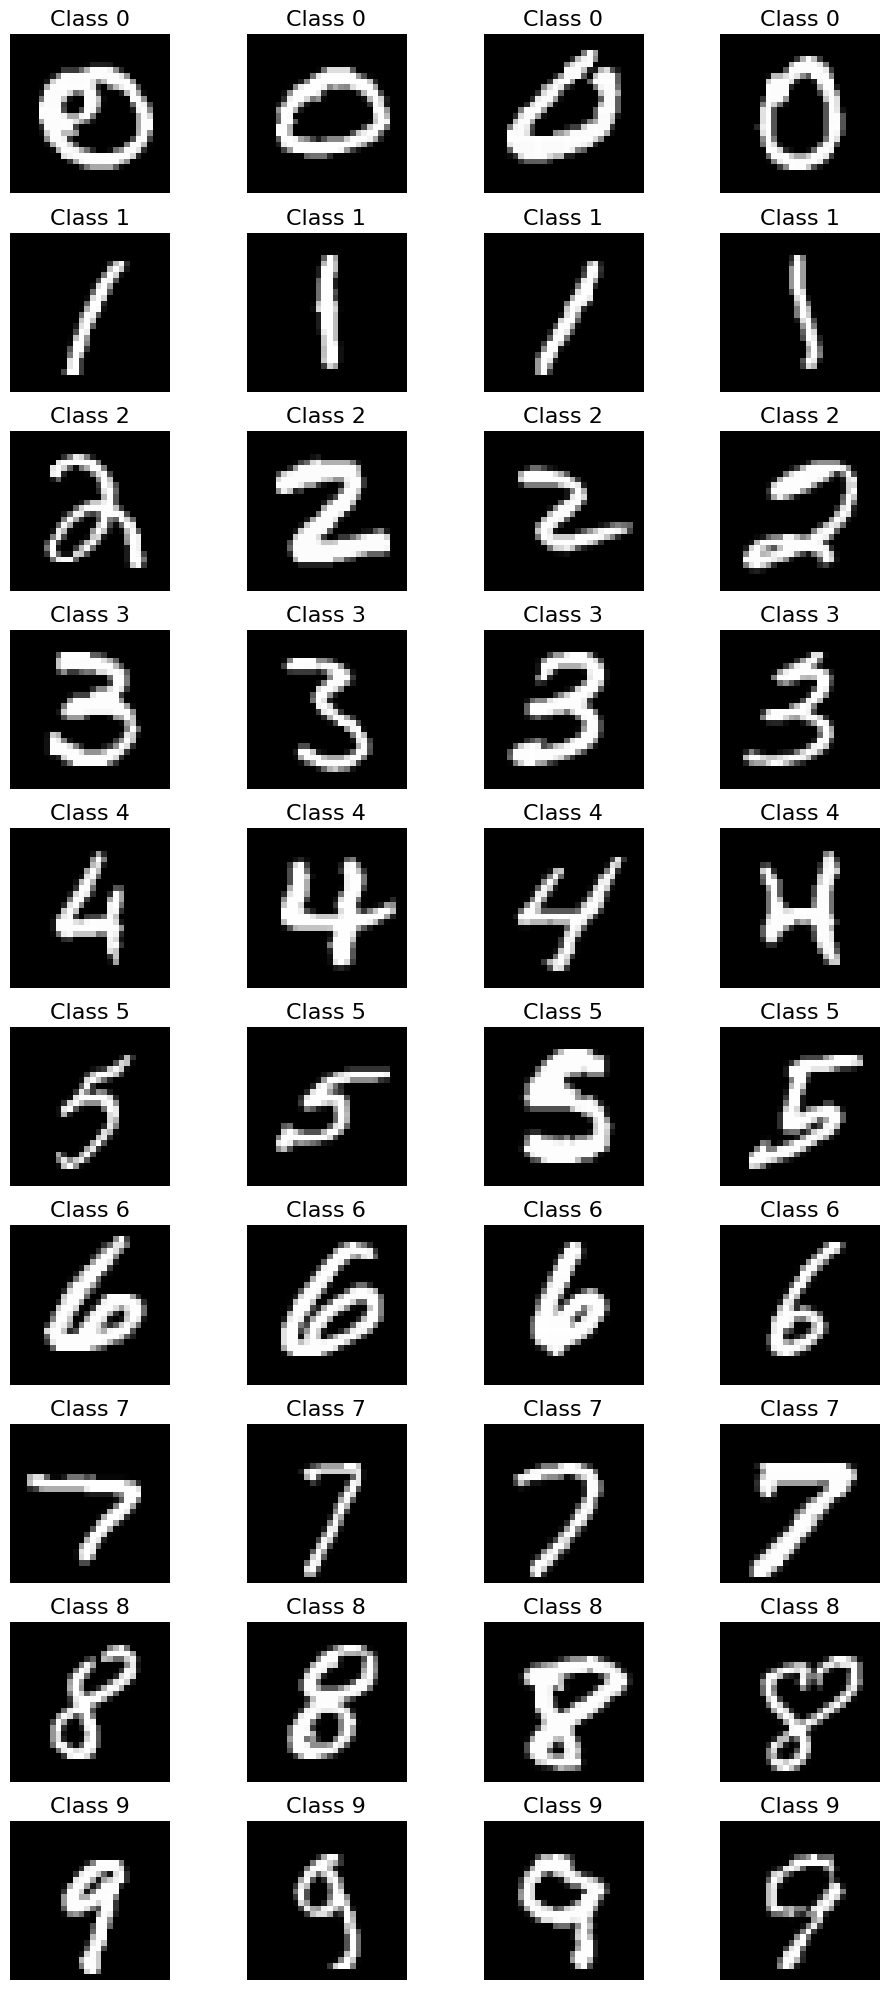

In [5]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE) with MLP Architectures We will implement these models using Multi-Layer Perceptrons (MLP) 

# 1) VAE --> MLP

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Sigmoid activation for output reconstruction
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode input to latent space
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        # Reparameterization trick to sample from the latent space
        z = self.reparameterize(mu, logvar)
        
        # Decode the sampled latent space representation
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

    def sample_from_latent_space(self, x, num_samples=1):
        # Generate random samples from the latent space
        with torch.no_grad():
            z = torch.randn(num_samples, self.fc_mu.out_features).to(x.device)
            generated_samples = self.decoder(z)
        return generated_samples


In [8]:
def vae_loss(recon, data, mu, logvar):
    # Reconstruction loss (negative log likelihood)
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')
    
    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss as the sum of reconstruction and KL divergence losses
    total_loss = reconstruction_loss + kl_divergence
    return total_loss


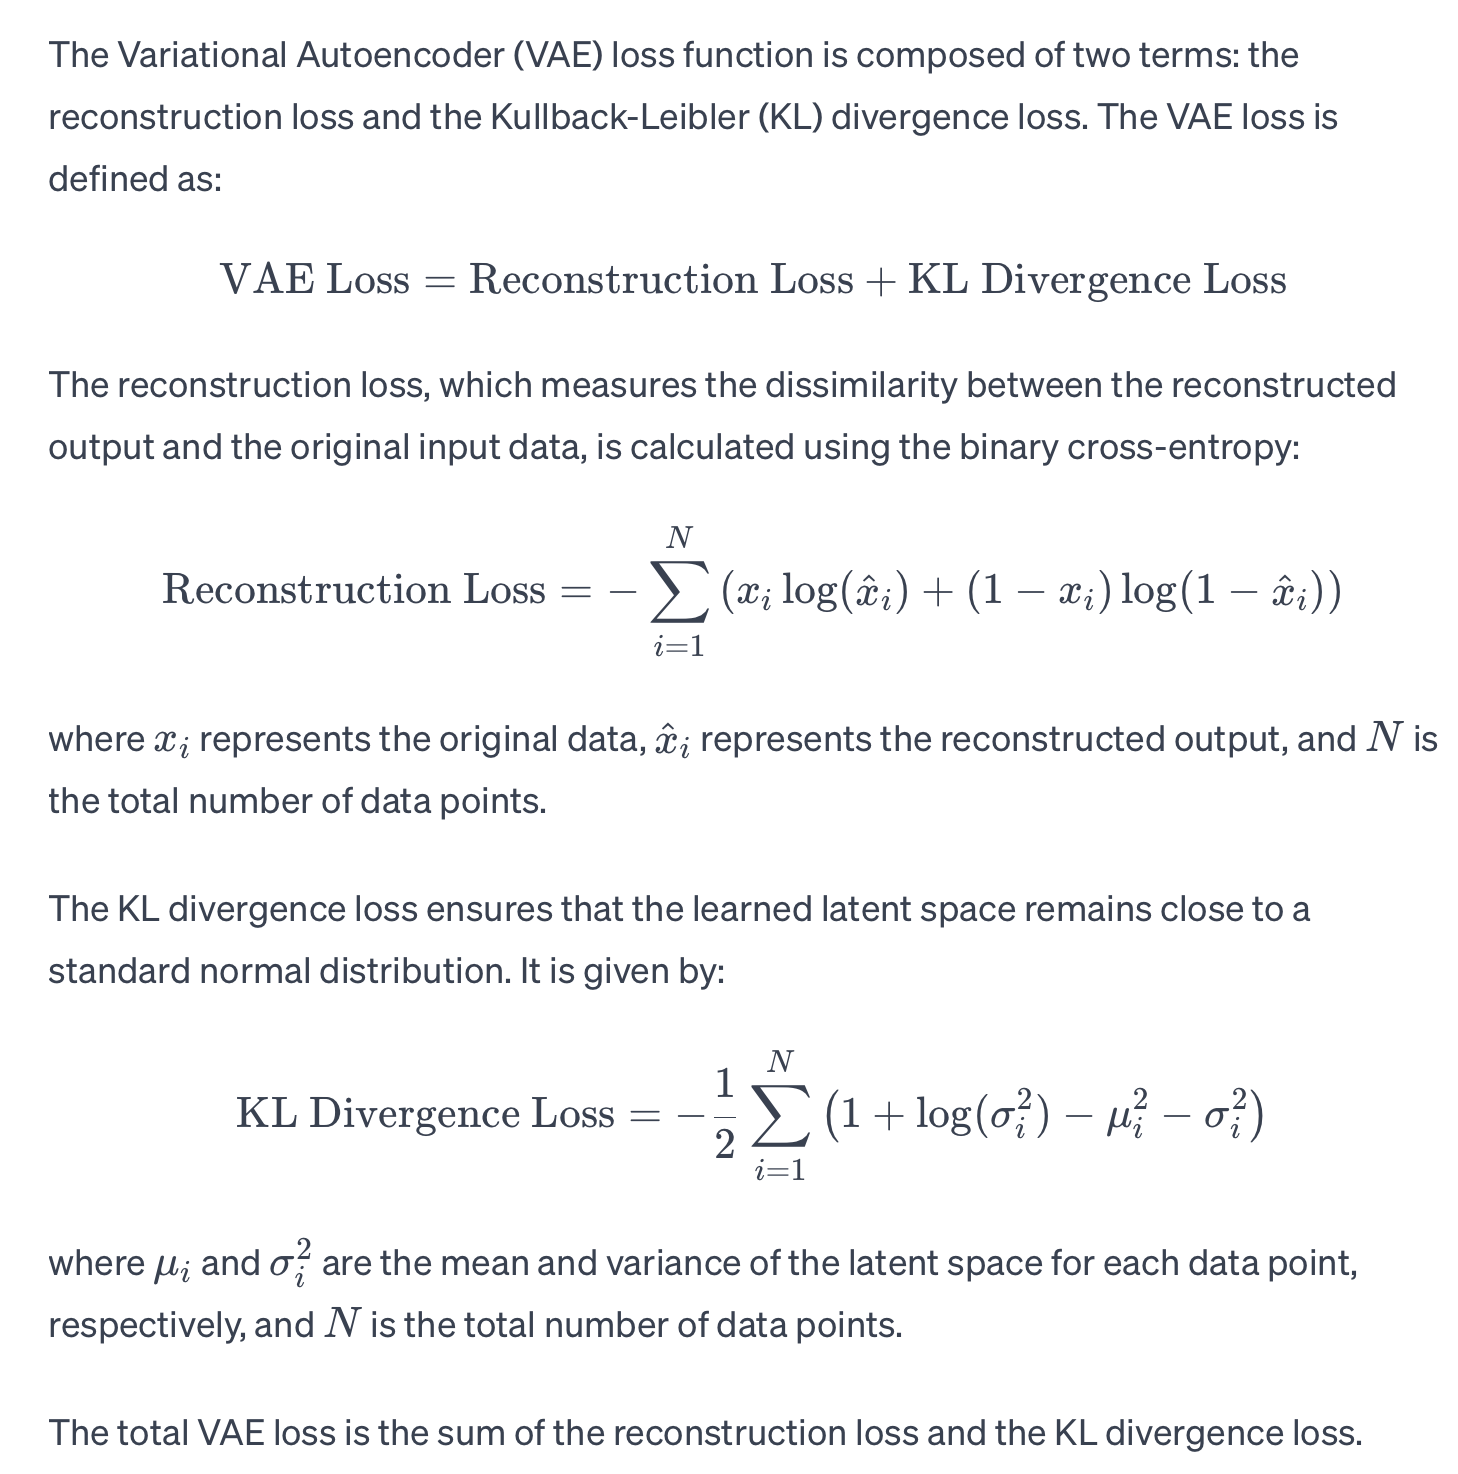



In [9]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Assuming vae_loss is defined somewhere

def train_vae_mlp(model, train_loader, num_epochs=20, learning_rate=1e-3, device='cuda'):
    model.to(device)  # Move the model to GPU
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0

        # Use tqdm for progress bar
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as t:
            for batch_idx, (data, _) in enumerate(t):
                data = data.to(device)  # Move the data to GPU
                optimizer.zero_grad()
                data = data.view(-1, 28*28)  # Flatten MNIST images
                recon, mu, logvar = model(data)
                loss = vae_loss(recon, data, mu, logvar)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                # Update tqdm description with current loss
                t.set_postfix(loss=total_loss / ((batch_idx + 1) * len(data)))

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")


In [10]:
input_dim = 28 * 28  # MNIST image size
hidden_dim = 256  # Example hidden layer dimension
latent_dim = 2  # Example latent space dimension
vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)

# Train the VAE-MLP model
train_vae_mlp(vae_mlp, train_loader)


##################################################


Epoch 1/20: 100%|██████████| 938/938 [00:11<00:00, 80.23batch/s, loss=359]


VAE-MLP Epoch [1/20], Loss: 179.51743372395833

##################################################


Epoch 2/20: 100%|██████████| 938/938 [00:11<00:00, 84.34batch/s, loss=317]


VAE-MLP Epoch [2/20], Loss: 158.58400358072916

##################################################


Epoch 3/20: 100%|██████████| 938/938 [00:10<00:00, 85.47batch/s, loss=309]


VAE-MLP Epoch [3/20], Loss: 154.6871934000651

##################################################


Epoch 4/20: 100%|██████████| 938/938 [00:11<00:00, 83.08batch/s, loss=305]


VAE-MLP Epoch [4/20], Loss: 152.5712041341146

##################################################


Epoch 5/20: 100%|██████████| 938/938 [00:11<00:00, 84.55batch/s, loss=301]


VAE-MLP Epoch [5/20], Loss: 150.71719497884115

##################################################


Epoch 6/20: 100%|██████████| 938/938 [00:11<00:00, 83.92batch/s, loss=298]


VAE-MLP Epoch [6/20], Loss: 149.31462135416666

##################################################


Epoch 7/20: 100%|██████████| 938/938 [00:11<00:00, 83.78batch/s, loss=296]


VAE-MLP Epoch [7/20], Loss: 147.93057565104166

##################################################


Epoch 8/20: 100%|██████████| 938/938 [00:11<00:00, 83.54batch/s, loss=294]


VAE-MLP Epoch [8/20], Loss: 147.03863063151042

##################################################


Epoch 9/20: 100%|██████████| 938/938 [00:11<00:00, 82.97batch/s, loss=292]


VAE-MLP Epoch [9/20], Loss: 146.17864248046874

##################################################


Epoch 10/20: 100%|██████████| 938/938 [00:11<00:00, 85.14batch/s, loss=291]


VAE-MLP Epoch [10/20], Loss: 145.6249194824219

##################################################


Epoch 11/20: 100%|██████████| 938/938 [00:10<00:00, 85.47batch/s, loss=290]


VAE-MLP Epoch [11/20], Loss: 144.83237928059896

##################################################


Epoch 12/20: 100%|██████████| 938/938 [00:11<00:00, 82.82batch/s, loss=290]


VAE-MLP Epoch [12/20], Loss: 144.98642412923178

##################################################


Epoch 13/20: 100%|██████████| 938/938 [00:11<00:00, 84.85batch/s, loss=289]


VAE-MLP Epoch [13/20], Loss: 144.4452629313151

##################################################


Epoch 14/20: 100%|██████████| 938/938 [00:10<00:00, 85.82batch/s, loss=287]


VAE-MLP Epoch [14/20], Loss: 143.6406989420573

##################################################


Epoch 15/20: 100%|██████████| 938/938 [00:11<00:00, 84.12batch/s, loss=286]


VAE-MLP Epoch [15/20], Loss: 143.25118669433593

##################################################


Epoch 16/20: 100%|██████████| 938/938 [00:11<00:00, 84.21batch/s, loss=286]


VAE-MLP Epoch [16/20], Loss: 143.11396720377604

##################################################


Epoch 17/20: 100%|██████████| 938/938 [00:10<00:00, 85.50batch/s, loss=285]


VAE-MLP Epoch [17/20], Loss: 142.66412426757813

##################################################


Epoch 18/20: 100%|██████████| 938/938 [00:10<00:00, 85.64batch/s, loss=284]


VAE-MLP Epoch [18/20], Loss: 142.30926169433593

##################################################


Epoch 19/20: 100%|██████████| 938/938 [00:11<00:00, 84.80batch/s, loss=283]


VAE-MLP Epoch [19/20], Loss: 141.65339130045572

##################################################


Epoch 20/20: 100%|██████████| 938/938 [00:10<00:00, 85.61batch/s, loss=284]


VAE-MLP Epoch [20/20], Loss: 142.00459608561198
Best model saved as 'best_vae_mlp_model.pth'


# 2) CVAE --> MLP

In [27]:
import torch.nn as nn
import torch

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_class = nn.Linear(hidden_dim // 2, num_classes)  # Class prediction layer

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Sigmoid activation for output reconstruction
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # Concatenate x and y before passing them to the encoder
        xy = torch.cat((x, y), dim=1)

        # Encoder
        hidden = self.encoder(xy)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        # Concatenate z and y before passing them to the decoder
        zy = torch.cat((z, y), dim=1)

        # Decoder
        reconstructed = self.decoder(zy)
        return reconstructed, mu, logvar, class_logits

    def sample_from_latent_space(self,x, num_samples=1, class_label=None):
        # Generate random samples from the latent space
        with torch.no_grad():
            z = torch.randn(num_samples, latent_dim).to(x.device)
            if class_label is not None:
                class_label = torch.tensor(class_label).to(x.device)
                zy = torch.cat((z, class_label), dim=1)
            else:
                zy = z
            generated_samples = self.decoder(zy)
        return generated_samples

    
    


In [28]:
# Initialize the CVAE_MLP model with dummy dimensions
input_dim = 784  # Example input dimension
hidden_dim = 256  # Example hidden dimension
latent_dim = 2  # Example latent dimension
num_classes = 10  # Example number of classes

# Create dummy input tensors
x_dummy = torch.randn(32, input_dim)  # Example batch size 32
y_dummy = torch.randn(32, num_classes)  # Example batch size 32

# Create an instance of the CVAE_MLP model
cvae_model = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes)

# Forward pass with the dummy inputs
recon_output, mu_output, logvar_output, class_logits_output = cvae_model(x_dummy, y_dummy)

# Print the sizes/shapes of the outputs for verification
print("Reconstructed Output Shape:", recon_output.shape)
print("Mu Output Shape:", mu_output.shape)
print("Logvar Output Shape:", logvar_output.shape)
print("Class Logits Output Shape:", class_logits_output.shape)


Reconstructed Output Shape: torch.Size([32, 784])
Mu Output Shape: torch.Size([32, 2])
Logvar Output Shape: torch.Size([32, 2])
Class Logits Output Shape: torch.Size([32, 10])


In [29]:
import torch
import torch.nn.functional as F

def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the recon tensor to match the shape of the data tensor
    recon = recon.view(recon.size(0), -1)
    
    # Flatten the data tensor
    data = data.view(data.size(0), -1)
    
    # Apply sigmoid activation to recon to ensure values are between 0 and 1
    recon = torch.sigmoid(recon)
    
    # Reconstruction loss (negative log likelihood)
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction='mean')

    # Total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    total_loss = reconstruction_loss + kl_divergence + ce_loss
    return total_loss


In [30]:
# Define some sample data for testing
batch_size = 32
input_dim = 28 * 28
latent_dim = 2
num_classes = 10

# Sample tensors with random data
recon_tensor = torch.randn(batch_size, 1, 28, 28)  # Sample reconstructed tensor
data_tensor = torch.randn(batch_size, input_dim)    # Sample data tensor
mu_tensor = torch.randn(batch_size, latent_dim)     # Sample mu tensor
logvar_tensor = torch.randn(batch_size, latent_dim) # Sample logvar tensor
class_logits_tensor = torch.randn(batch_size, num_classes)  # Sample class logits tensor
labels_tensor = torch.randint(0, num_classes, (batch_size,)) # Sample labels tensor

# Test cvae_loss function
loss = cvae_loss(recon_tensor, data_tensor, mu_tensor, logvar_tensor, class_logits_tensor, labels_tensor)
print("Loss:", loss.item())


Loss: 20208.779296875


In [34]:
def train_cvae_mlp(model, train_loader, num_epochs=20, learning_rate=1e-3, device='cuda'):
    model.to(device)  # Move the entire model to the specified device
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    print(f"Training on device: {device}")

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0

        # Use tqdm for progress bar
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as t:
            for batch_idx, (data, labels) in enumerate(t):
                data = data.to(device)  # Move the data to the specified device
                labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)  # Move labels to the GPU

                optimizer.zero_grad()
                recon, mu, logvar, class_logits = model(data, labels_one_hot)
                labels = labels.to(device)  # Move labels to the GPU
                loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)
                
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                # Update tqdm description with current loss
                t.set_postfix(loss=total_loss / ((batch_idx + 1) * len(data)))

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                z = torch.randn(num_classes * num_samples_per_class, 2).to(device)
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1).to(device)
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")


Training on device: cuda

##################################################


Epoch 1/20: 100%|██████████| 938/938 [00:11<00:00, 80.53batch/s, loss=1.09e+3]


CVAE-MLP Epoch [1/20], Loss: 545.4495610677084
Sample Images:


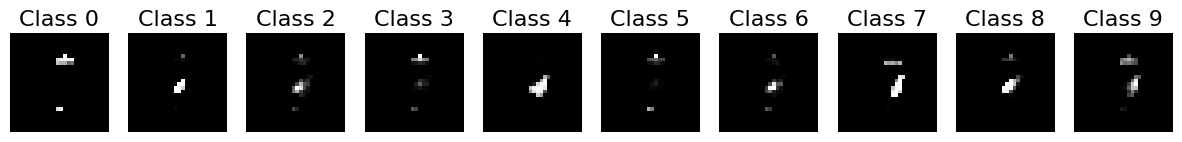


##################################################


Epoch 2/20: 100%|██████████| 938/938 [00:11<00:00, 82.53batch/s, loss=1.08e+3]


CVAE-MLP Epoch [2/20], Loss: 541.8362180989583
Sample Images:


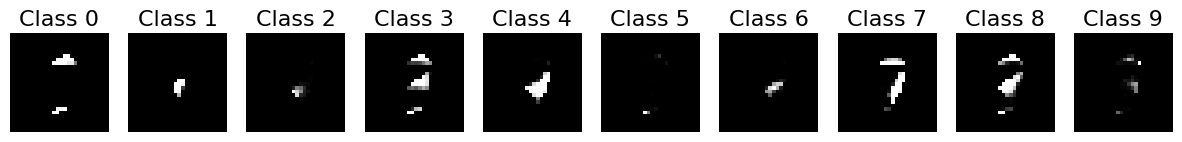


##################################################


Epoch 3/20: 100%|██████████| 938/938 [00:11<00:00, 81.34batch/s, loss=1.08e+3]


CVAE-MLP Epoch [3/20], Loss: 541.4045609700521
Sample Images:


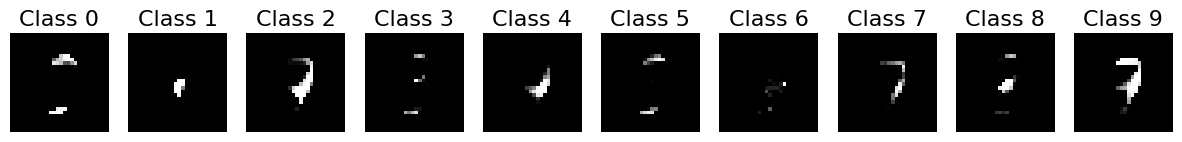


##################################################


Epoch 4/20: 100%|██████████| 938/938 [00:11<00:00, 81.39batch/s, loss=1.08e+3]


CVAE-MLP Epoch [4/20], Loss: 541.1050527669271
Sample Images:


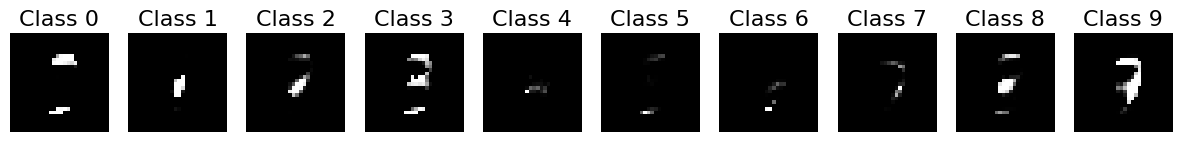


##################################################


Epoch 5/20: 100%|██████████| 938/938 [00:11<00:00, 81.54batch/s, loss=1.08e+3]


CVAE-MLP Epoch [5/20], Loss: 540.6500150716146
Sample Images:


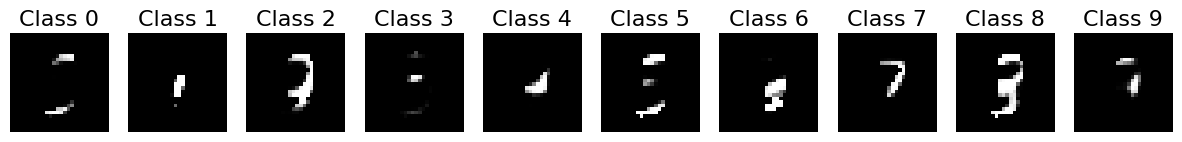


##################################################


Epoch 6/20: 100%|██████████| 938/938 [00:11<00:00, 80.24batch/s, loss=1.08e+3]


CVAE-MLP Epoch [6/20], Loss: 540.1848906901041
Sample Images:


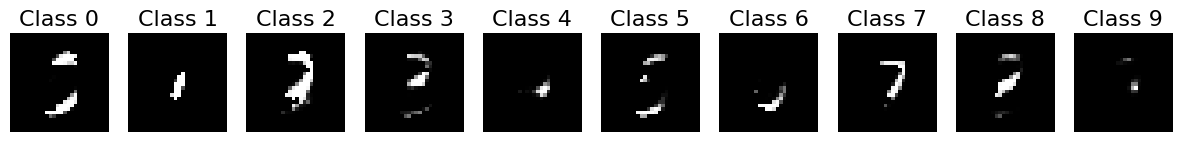


##################################################


Epoch 7/20: 100%|██████████| 938/938 [00:11<00:00, 82.32batch/s, loss=1.08e+3]


CVAE-MLP Epoch [7/20], Loss: 539.6400475585938
Sample Images:


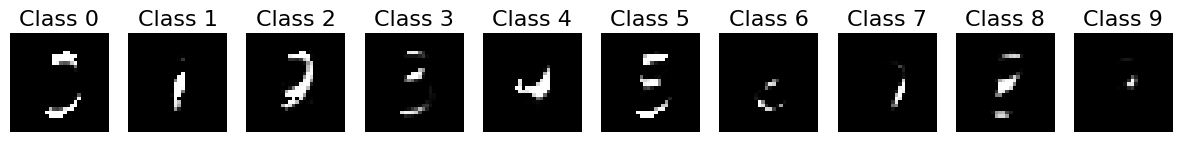


##################################################


Epoch 8/20: 100%|██████████| 938/938 [00:11<00:00, 80.65batch/s, loss=1.08e+3]


CVAE-MLP Epoch [8/20], Loss: 539.112400748698
Sample Images:


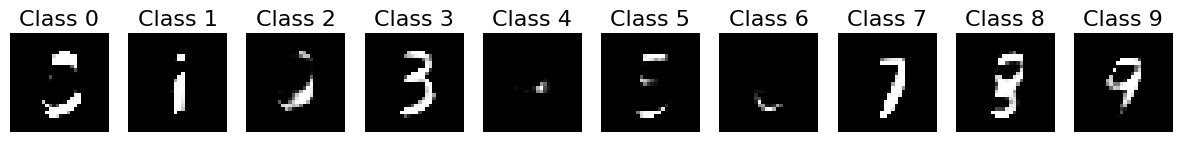


##################################################


Epoch 9/20: 100%|██████████| 938/938 [00:11<00:00, 83.53batch/s, loss=1.08e+3]


CVAE-MLP Epoch [9/20], Loss: 538.7939552408855
Sample Images:


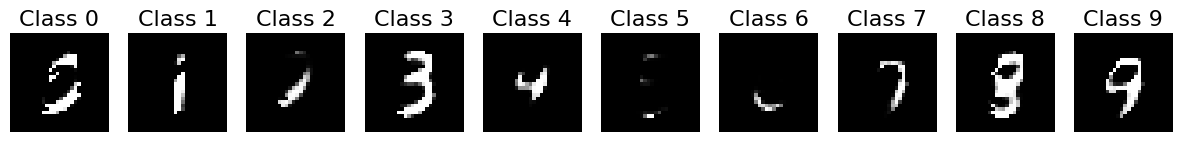


##################################################


Epoch 10/20: 100%|██████████| 938/938 [00:11<00:00, 79.24batch/s, loss=1.08e+3]


CVAE-MLP Epoch [10/20], Loss: 538.5442545898437
Sample Images:


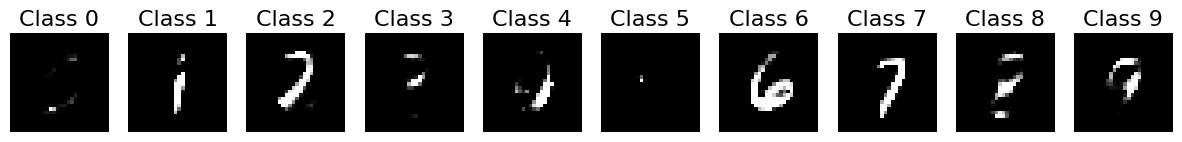


##################################################


Epoch 11/20: 100%|██████████| 938/938 [00:11<00:00, 82.23batch/s, loss=1.08e+3]


CVAE-MLP Epoch [11/20], Loss: 538.3064468098959
Sample Images:


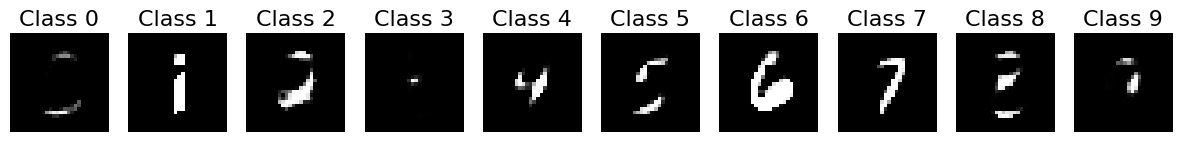


##################################################


Epoch 12/20: 100%|██████████| 938/938 [00:11<00:00, 81.65batch/s, loss=1.08e+3]


CVAE-MLP Epoch [12/20], Loss: 538.1550034505208
Sample Images:


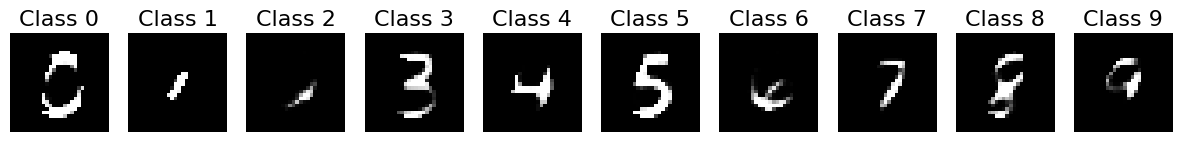


##################################################


Epoch 13/20: 100%|██████████| 938/938 [00:11<00:00, 79.43batch/s, loss=1.08e+3]


CVAE-MLP Epoch [13/20], Loss: 538.0654928059896
Sample Images:


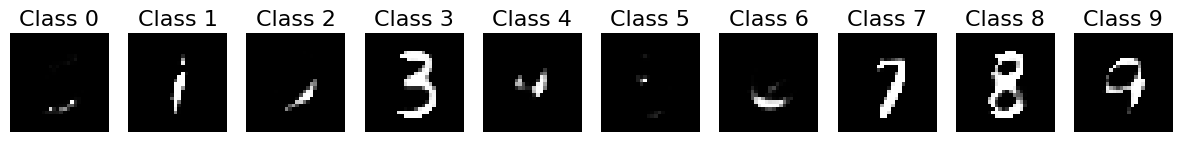


##################################################


Epoch 14/20: 100%|██████████| 938/938 [00:11<00:00, 82.92batch/s, loss=1.08e+3]


CVAE-MLP Epoch [14/20], Loss: 537.9624918945312
Sample Images:


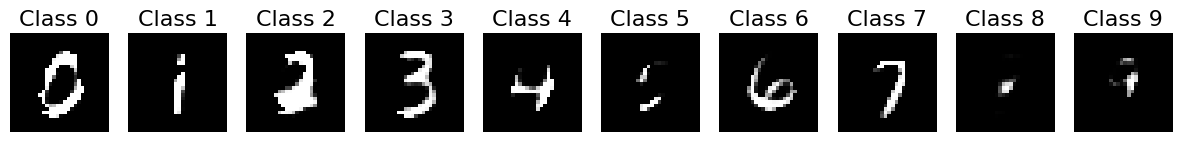


##################################################


Epoch 15/20: 100%|██████████| 938/938 [00:11<00:00, 79.46batch/s, loss=1.08e+3]


CVAE-MLP Epoch [15/20], Loss: 537.8646133138021
Sample Images:


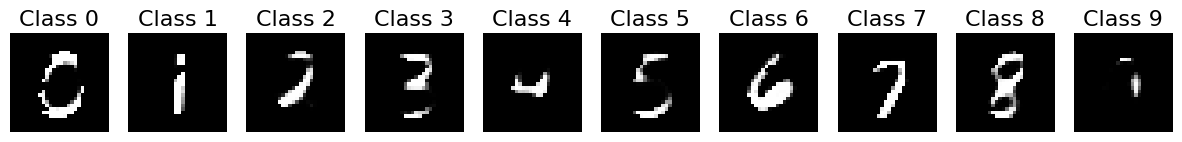


##################################################


Epoch 16/20: 100%|██████████| 938/938 [00:11<00:00, 82.23batch/s, loss=1.08e+3]


CVAE-MLP Epoch [16/20], Loss: 537.7986411458334
Sample Images:


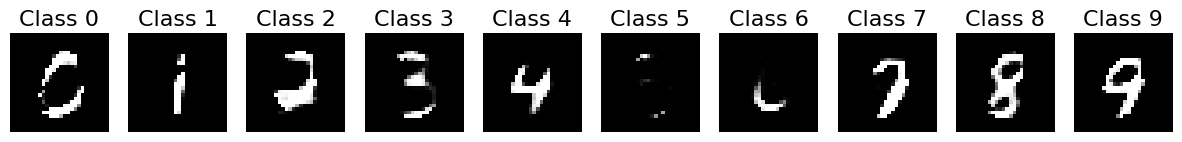


##################################################


Epoch 17/20: 100%|██████████| 938/938 [00:11<00:00, 80.06batch/s, loss=1.07e+3]


CVAE-MLP Epoch [17/20], Loss: 537.7109823893229
Sample Images:


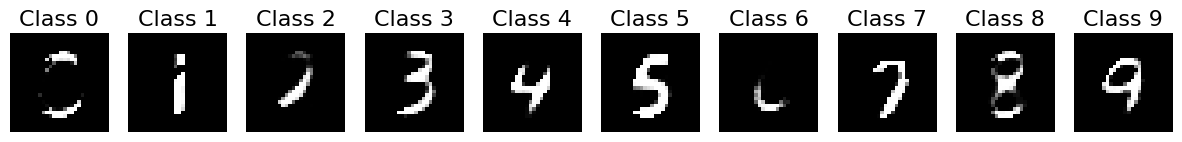


##################################################


Epoch 18/20: 100%|██████████| 938/938 [00:11<00:00, 81.30batch/s, loss=1.07e+3]


CVAE-MLP Epoch [18/20], Loss: 537.659346516927
Sample Images:


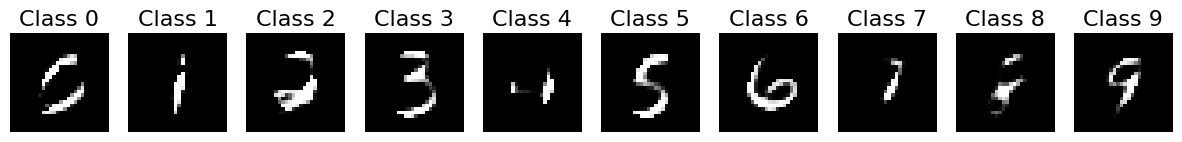


##################################################


Epoch 19/20: 100%|██████████| 938/938 [00:11<00:00, 79.51batch/s, loss=1.07e+3]


CVAE-MLP Epoch [19/20], Loss: 537.6145316731771
Sample Images:


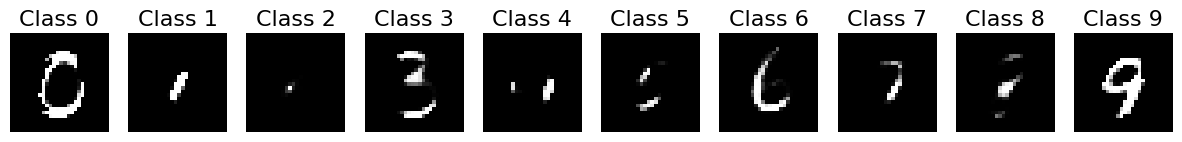


##################################################


Epoch 20/20: 100%|██████████| 938/938 [00:11<00:00, 79.91batch/s, loss=1.07e+3]


CVAE-MLP Epoch [20/20], Loss: 537.5731176432291
Sample Images:


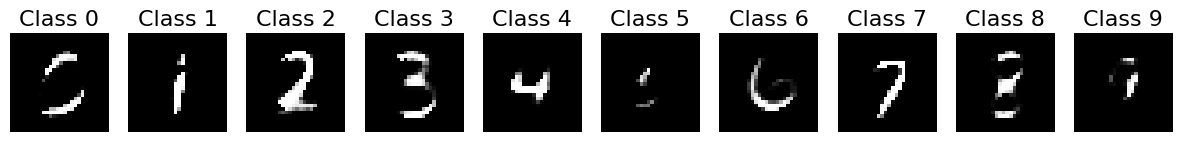

Best model saved as 'best_cvae_mlp_model.pth'


In [35]:

# Set necessary dimensions
input_dim = 28 * 28  # MNIST image size
hidden_dim = 256  # Example hidden layer dimension
latent_dim = 2  # Example latent space dimension
num_classes = 10  # Number of classes (0 to 9)

# Instantiate CVAE_MLP with provided dimensions
cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes)

# Train the CVAE using train_loader
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


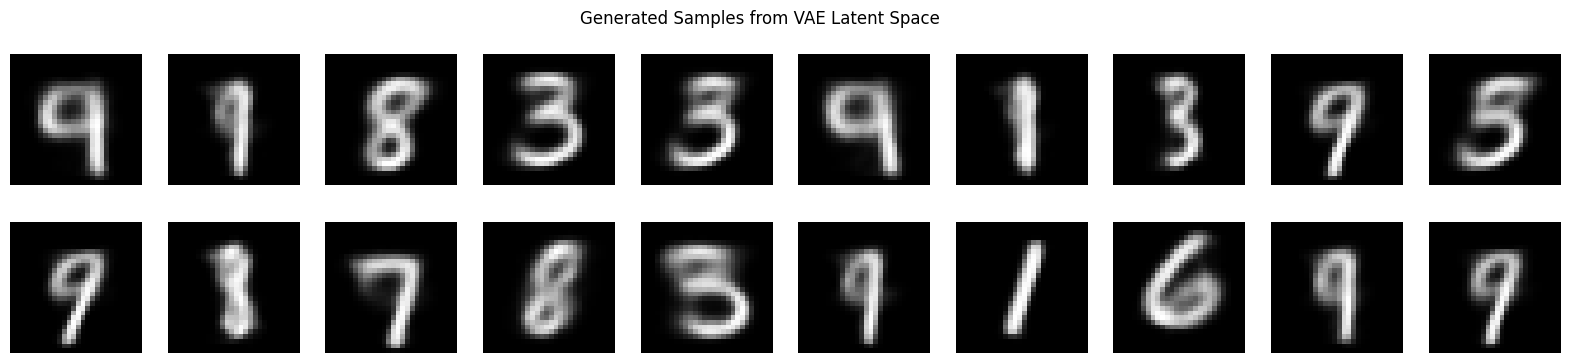

In [36]:
import torchvision
import matplotlib.pyplot as plt

# Assuming vae_mlp is your VAE model
vae_mlp.eval()  # Set the model to evaluation mode
vae_mlp.to(device)  # Move the entire model to the specified device

# Set the number of samples to generate
num_samples = 20

# Assuming x is your input tensor
x = torch.randn(num_samples, input_dim).to(device)  # Move x to the specified device

# Generate random samples from the latent space
generated_samples = vae_mlp.sample_from_latent_space(x, num_samples)

# Plot the generated samples
fig, axes = plt.subplots(2, 10, figsize=(20, 4))  # 2 rows, 10 columns

for i in range(num_samples):
    sample = generated_samples[i].squeeze().detach().cpu().numpy()
    sample = sample.reshape((28, 28))
    
    row = i // 10
    col = i % 10
    
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

# Add title to the entire plot
plt.suptitle("Generated Samples from VAE Latent Space")
plt.show()


/tmp/ipykernel_42/1177987258.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_label = torch.tensor(class_label).to(x.device)


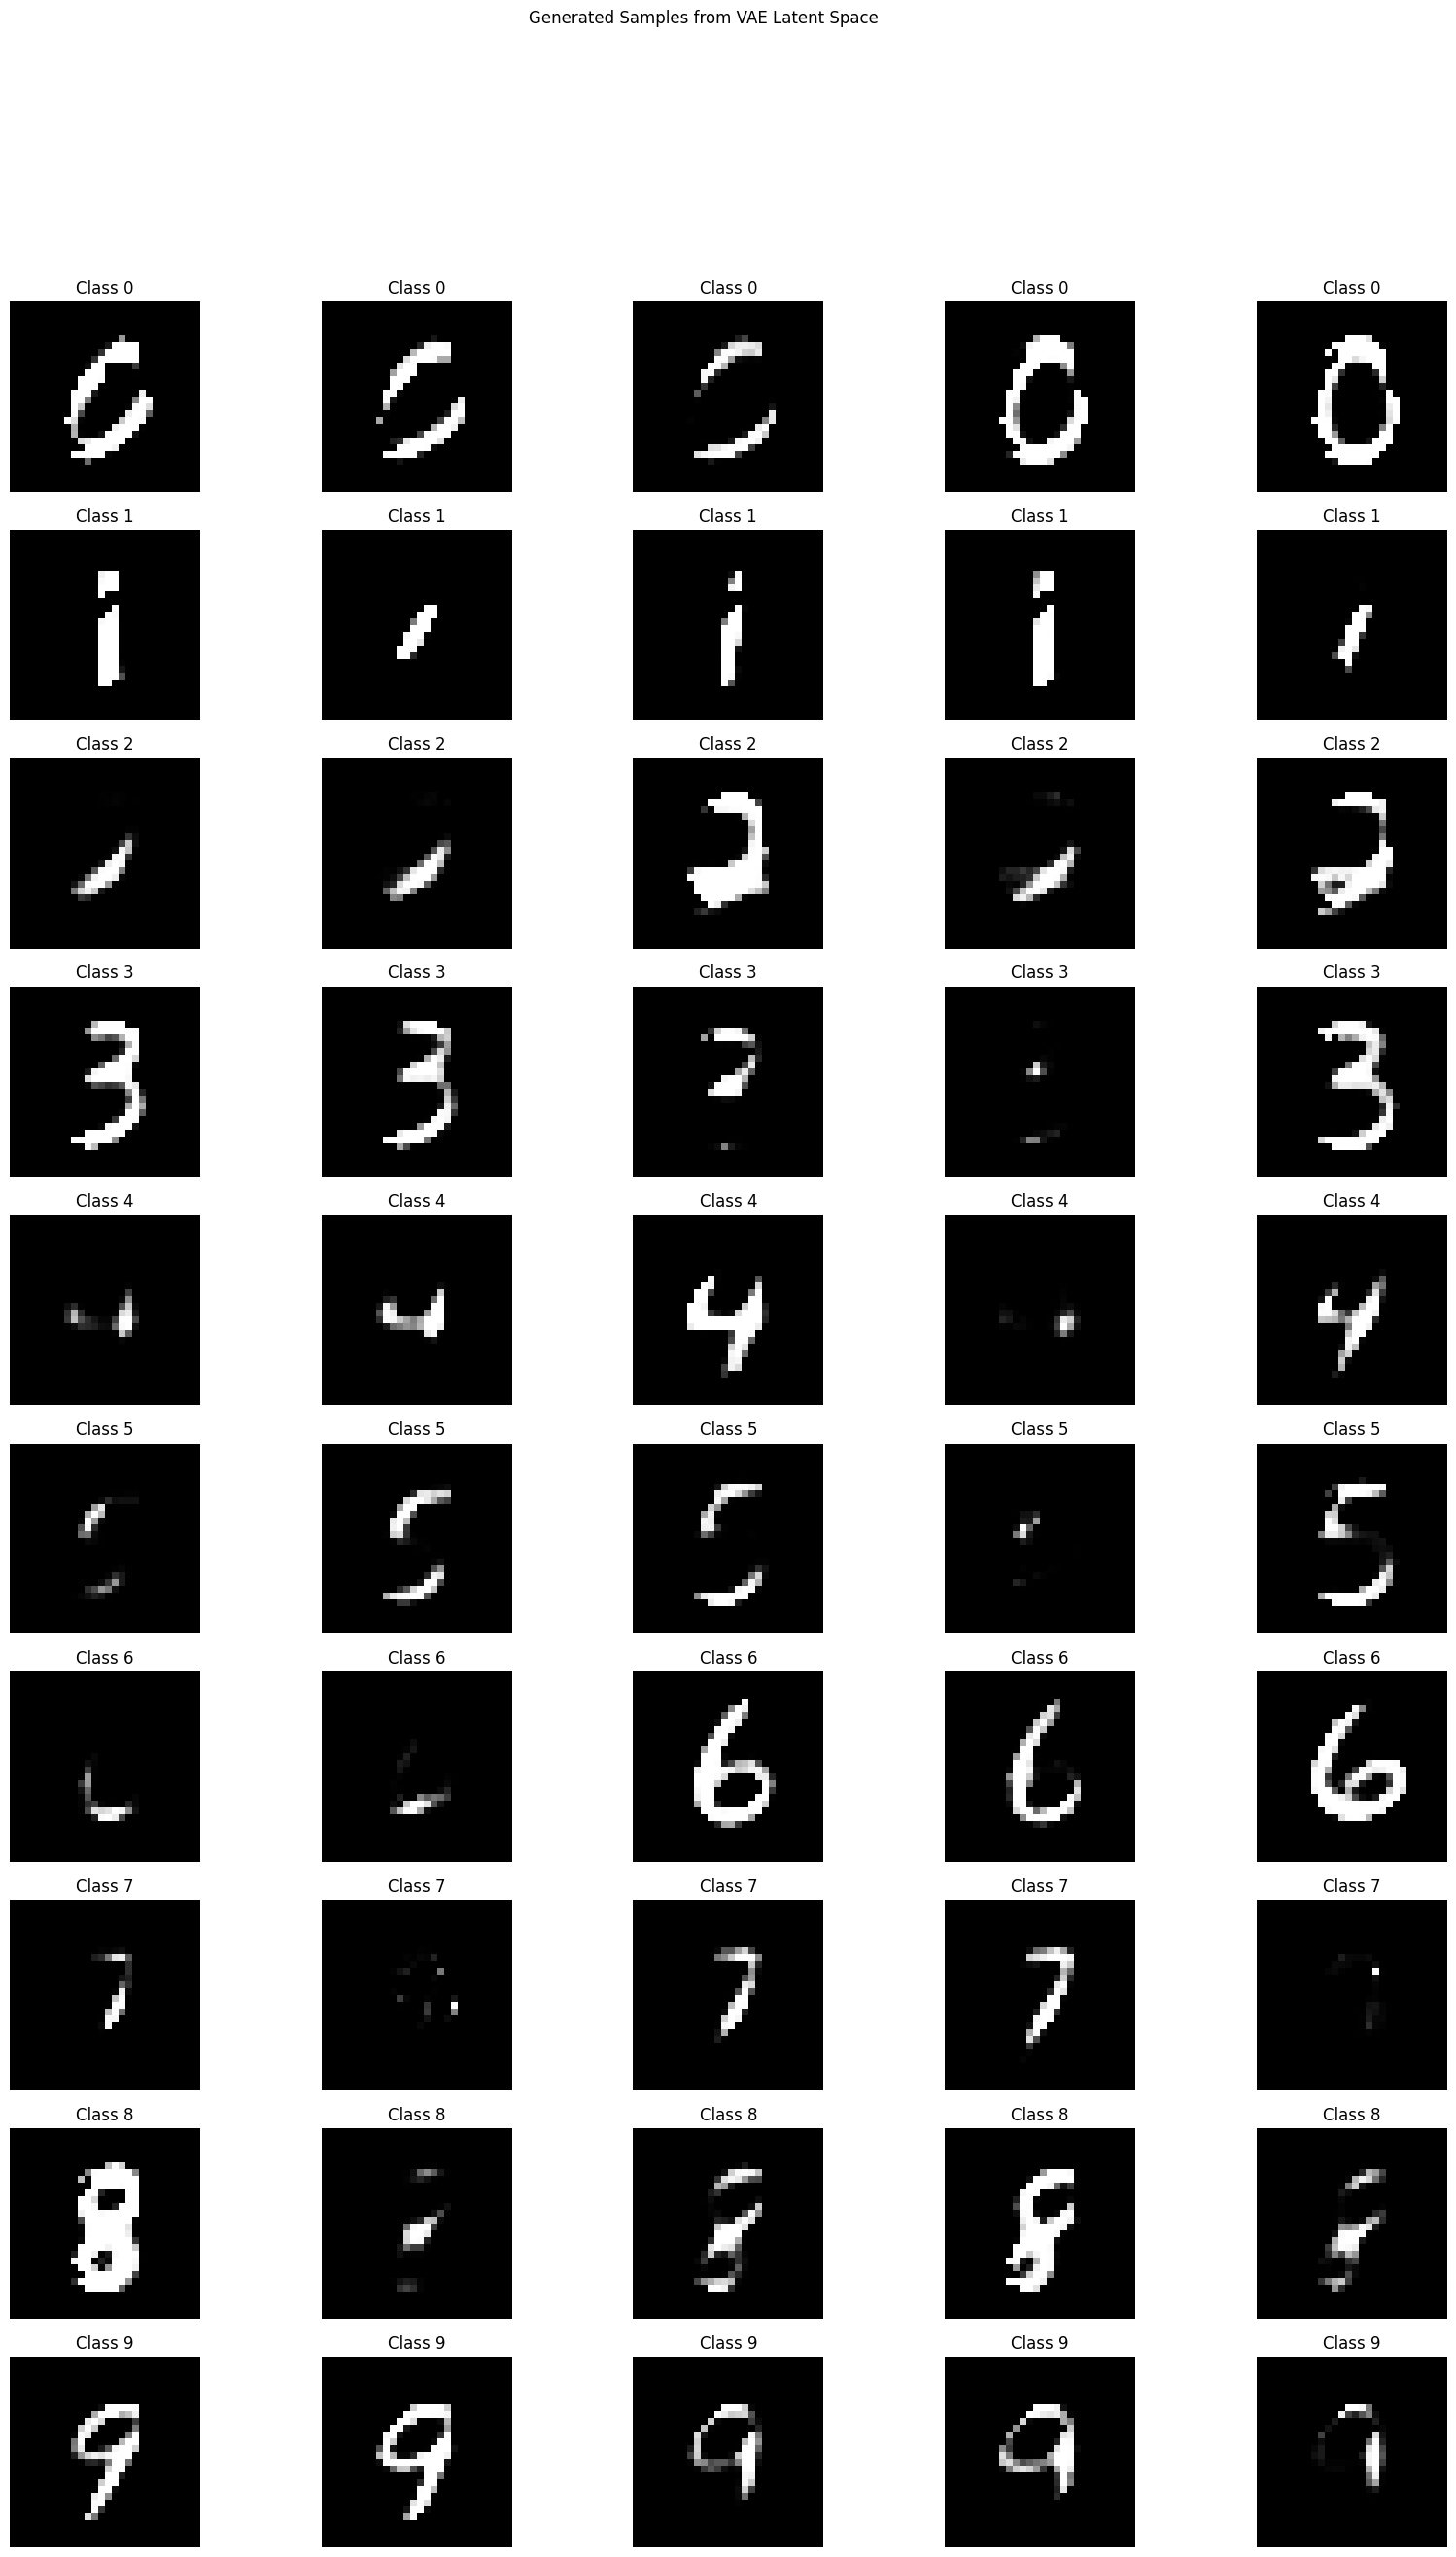

In [39]:
def test_generate_samples_with_class(cvae_mlp, num_samples_per_class=5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    fig, axes = plt.subplots(10, num_samples_per_class, figsize=(20, 30))

    for class_label in range(10):
        x = torch.randn(num_samples_per_class, input_dim).to(device)
        class_label_tensor = F.one_hot(torch.tensor([class_label] * num_samples_per_class), num_classes=10).float().to(device)
        generated_samples = cvae_mlp.sample_from_latent_space(x, num_samples_per_class, class_label_tensor)

        for i in range(num_samples_per_class):
            sample = generated_samples[i].squeeze().detach().cpu().numpy()
            sample = sample.reshape((28, 28))
            
            axes[class_label, i].imshow(sample, cmap='gray')
            axes[class_label, i].axis('off')
            axes[class_label, i].set_title(f"Class {class_label}")

    plt.suptitle("Generated Samples from VAE Latent Space")
    plt.show()
 

cvae_mlp.eval()  # Set the model to evaluation mode
test_generate_samples_with_class(cvae_mlp)
